<a href="https://colab.research.google.com/github/suryakantk94/artistGan/blob/main/Copy_of_Cycle_gan_FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/MyDrive


In [5]:
!unzip drive/MyDrive/monet2photo.zip

Streaming output truncated to the last 5000 lines.
  inflating: monet2photo/trainB/2016-03-31 05:58:36.jpg  
  inflating: monet2photo/trainB/2014-01-10 12:46:39.jpg  
  inflating: monet2photo/trainB/2015-02-23 11:45:00.jpg  
  inflating: monet2photo/trainB/2015-05-23 09:38:08.jpg  
  inflating: monet2photo/trainB/2016-01-15 00:48:49.jpg  
  inflating: monet2photo/trainB/2016-12-27 18:15:26.jpg  
  inflating: monet2photo/trainB/2017-01-02 11:16:05.jpg  
  inflating: monet2photo/trainB/2015-08-06 11:08:32.jpg  
  inflating: monet2photo/trainB/2015-12-16 07:43:36.jpg  
  inflating: monet2photo/trainB/2016-03-25 12:57:28.jpg  
  inflating: monet2photo/trainB/2016-05-10 11:44:44.jpg  
  inflating: monet2photo/trainB/2015-03-11 08:01:52.jpg  
  inflating: monet2photo/trainB/2015-08-30 05:26:05.jpg  
  inflating: monet2photo/trainB/2015-10-03 19:00:56.jpg  
  inflating: monet2photo/trainB/2016-06-08 02:40:47.jpg  
  inflating: monet2photo/trainB/2016-02-28 23:11:19.jpg  
  inflating: monet2ph

Loaded dataA:  (1072, 256, 256, 3)
Loaded dataB:  (6287, 256, 256, 3)


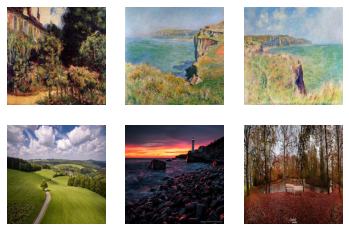

Loaded (50, 256, 256, 3) (50, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Iteration>1, dA[0.859,0.968] dB[1.168,0.806] g[18.403,19.409]
Iteration>2, dA[3.774,0.977] dB[8.606,1.774] g[21.714,24.283]
Iteration>3, dA[4.863,1.769] dB[7.618,1.023] g[16.594,17.483]
Iteration>4, dA[12.667,1.757] dB[3.337,0.931] g[15.615,20.521]
Iteration>5, dA[2.863,3.963] dB[2.269,0.788] g[15.731,20.415]
Iteration>6, dA[1.523,2.379] dB[3.418,1.275] g[17.387,18.803]
Iteration>7, dA[0.953,1.683] dB[3.934,1.469] g[13.658,16.312]
Iteration>8, dA[0.765,1.913] dB[3.485,1.346] g[14.768,16.311]
Iteration>9, dA[1.357,4.391] dB[1.944,2.232] g[14.793,18.210]
Iteration>10, dA[2.182,2.471] dB[1.318,1.789] g[16.499,15.795]
Iteration>11, dA[0.872,1.960] dB[1.249,0.891] g[12.665,14.830]
Iteration>12, dA[1.498,2.640] dB[0.817,0.915] g[11.152,12.799]
Iteration>13, dA[1.697,0.909] dB[0.824,0.665] g[13.582,13.364]
Iteration>14, dA[1.354,0.761] dB[0.792,0.758] g[10.991,11.981]
Iteration>15, dA[0.627,0.710] dB[0.678,0.457] g[11.691,12.076]
Iteration>16, dA[0.544,0.514] dB[0.376,0.528] g[14.229,14.428]


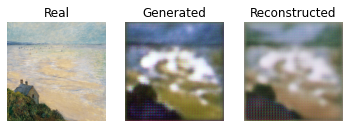

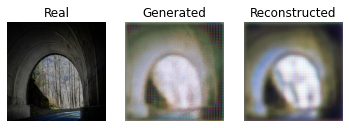

FileNotFoundError: ignored

In [1]:

# monet2photo
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
import numpy as np

# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)


# dataset path
path = 'monet2photo/'

# load dataset A - Monet paintings
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) 

# load dataset B - Photos 
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) 

# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()



# load image data
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

from cycleGAN_model import define_generator, define_discriminator, define_composite_model, train
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

############################################

# Use the saved cyclegan models for image translation
from instancenormalization import InstanceNormalization  
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5


# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('monet2photo_models/g_model_AtoB_000050.h5', cust)
model_BtoA = load_model('monet2photo_models/g_model_BtoA_000050.h5', cust)

# plot A->B->A (Monet to photo to Monet)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B (Photo to Monet to Photo)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

##########################
#Load a single custom image
test_image = load_img('monet2photo/sunset256.jpg')
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5

# plot B->A->B (Photo to Monet to Photo)
monet_generated  = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)

In [5]:
#Load a single custom image
test_image = load_img('monet2photo_models/cycling.jpg')
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5



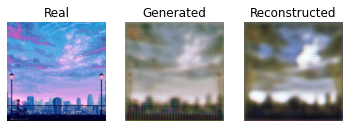

In [6]:
# plot B->A->B (Photo to Monet to Photo)
monet_generated  = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)